# Kiva Loan Data EDA and Analysis

### About Kiva
Kiva is an international nonprofit founded in 2005 with a mission to connect people through lending to alleviate poverty. In June 2018 Kiva was in 85 countries, and had served 2.9 Million borrowers through $ 1.16 Billion worth of loans.

### How it works
1. A borrower applies for a loan (micro-finance partner, or Kiva directly).
2. The loan goes through the underwriting and approval process.
3. The loan is posted to Kiva for lenders to support, and a 30-day fundraising period begins.
4. Borrowers repay the loans.
* Note that Kiva does not collect interest on loans, and Kiva lenders do not receive interest from loans they support on Kiva. However, Field Partners collect interest from borrowers to cover their operation costs.

### About Kiva's Data
This analysis uses Kiva's Data Snapshot (https://build.kiva.org/docs/data/snapshots) downloaded on June 15th, 2018.


## Libraries and Data

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts
%matplotlib inline

In [2]:
!ls kiva_ds_csv

lenders.csv       loans.csv         loans_lenders.csv


In [3]:
lenders = pd.read_csv('kiva_ds_csv/lenders.csv')

In [4]:
loans = pd.read_csv('kiva_ds_csv/loans.csv', parse_dates=['POSTED_TIME', 'PLANNED_EXPIRATION_TIME', 'DISBURSE_TIME',
       'RAISED_TIME'])

In [5]:
loans_lenders = pd.read_csv('kiva_ds_csv/loans_lenders.csv')

In [5]:
lenders.isnull().sum()

PERMANENT_NAME             0
DISPLAY_NAME            2768
MAIN_PIC_ID          1590116
CITY                 1619306
STATE                1713481
COUNTRY_CODE         1458635
MEMBER_SINCE               0
PERSONAL_URL         2189805
OCCUPATION           1844514
LOAN_BECAUSE         2174852
OTHER_INFO           2154640
LOAN_PURCHASE_NUM     894281
INVITED_BY           1852349
NUM_INVITED                0
dtype: int64

In [6]:
lenders.shape

(2349174, 14)

In [7]:
loans.shape

(1419607, 34)

In [10]:
loans_lenders.shape

(1387432, 2)

## Process data & Train-Test split

In [1]:
ls

Kiva_EDA.ipynb                       kiva_ds_csv/
Kiva_Matrix.ipynb                    kiva_spark_aws.ipynb
LenderPersonas2015Posters_FINAL.pdf  main.py
LightFM.ipynb                        private/
Pandas_ALS_CSR.ipynb                 processed_data/
README.md                            scripts/
References/                          spark-warehouse/
Spark_local_ALS_samples.ipynb        vocs.json


In [6]:
llt = pd.read_csv("processed_data/llt.csv")

In [9]:
llt.shape

(1387432, 3)

In [13]:
interactions_train = llt.iloc[:round(llt.shape[0]*0.8),:]

In [14]:
interactions_test = llt.iloc[(llt.shape[0] - round(llt.shape[0]*0.8))*-1:,:]

In [15]:
interactions_test.shape

(277486, 3)

In [16]:
interactions_train.shape

(1109946, 3)

## Lenders EDA

In [8]:
lenders = pd.read_csv('kiva_ds_csv/lenders.csv')

In [113]:
def find_percent(df,cols):
    mp = []
    for col in cols:
        percent = (df[col].isnull().sum()/df[col].isnull().count()*100).round(2)
        mp.append(percent)
    return mp

#plot each column histgram
def plot_columns(df, col_list,ncols,nrows,figsize):
    fig,axes = plt.subplots(ncols=ncols,nrows=nrows,figsize=figsize);
    axs = axes.ravel()
    for c,a,p in zip(col_list,axs,find_percent(df,col_list)):
        df[c].hist(ax=a);
        a.set_title("{} distribution ({}% missing values)".format(c,p),fontsize=10)



In [110]:
lenders.head()

,PERMANENT_NAME,DISPLAY_NAME,MAIN_PIC_ID,CITY,STATE,COUNTRY_CODE,MEMBER_SINCE,PERSONAL_URL,OCCUPATION,LOAN_BECAUSE,OTHER_INFO,LOAN_PURCHASE_NUM,INVITED_BY,NUM_INVITED
0,qian3013,Qian,NaN,NaN,NaN,NaN,1461300457,NaN,NaN,NaN,NaN,1.0,NaN,0
1,reena6733,Reena,NaN,NaN,NaN,NaN,1461300634,NaN,NaN,NaN,NaN,9.0,NaN,0
2,mai5982,Mai,NaN,NaN,NaN,NaN,1461300853,NaN,NaN,NaN,NaN,NaN,NaN,0
3,andrew86079135,Andrew,NaN,NaN,NaN,NaN,1461301091,NaN,NaN,NaN,NaN,5.0,Peter Tan,0
4,nguyen6962,Nguyen,NaN,NaN,NaN,NaN,1461301154,NaN,NaN,NaN,NaN,NaN,NaN,0


In [118]:
lenders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2349174 entries, 0 to 2349173
Data columns (total 14 columns):
PERMANENT_NAME       object
DISPLAY_NAME         object
MAIN_PIC_ID          float64
CITY                 object
STATE                object
COUNTRY_CODE         object
MEMBER_SINCE         int64
PERSONAL_URL         object
OCCUPATION           object
LOAN_BECAUSE         object
OTHER_INFO           object
LOAN_PURCHASE_NUM    float64
INVITED_BY           object
NUM_INVITED          int64
dtypes: float64(2), int64(2), object(10)
memory usage: 250.9+ MB


### 2. Feature Engineering


#### 2.1 Member Since

In [38]:
lenders['MEMBER_SINCE'] = pd.to_datetime(lenders['MEMBER_SINCE'],unit='s')

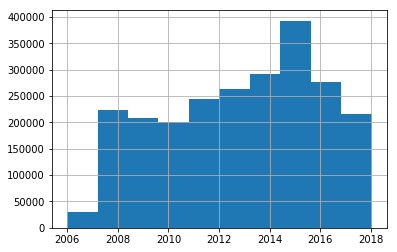

In [39]:
lenders['MEMBER_SINCE'].hist()

#### 2.1 Num_Loans_Purchased

In [41]:
lenders['LOAN_PURCHASE_NUM'] = lenders['LOAN_PURCHASE_NUM'].fillna(-1)

In [98]:
bins = [-2,-1,20,100,1000,85191]
lenders['binned_loan_purcharse_num'] = pd.cut(lenders['LOAN_PURCHASE_NUM'],bins)

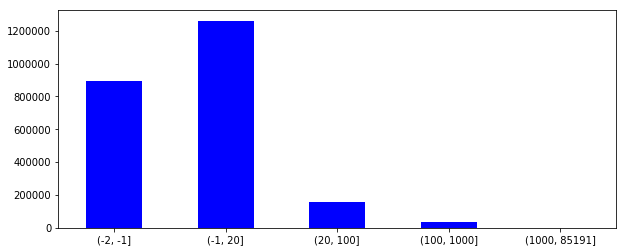

In [101]:
ax = lenders.binned_loan_purcharse_num.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(10,4))

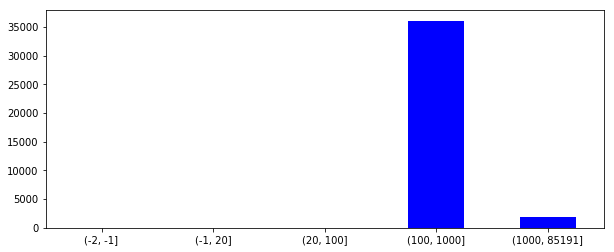

In [100]:
ax = lenders[lenders.LOAN_PURCHASE_NUM > 100]['binned_loan_purcharse_num'].value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(10,4))

In [65]:
lenders.head()

,PERMANENT_NAME,DISPLAY_NAME,MAIN_PIC_ID,CITY,STATE,COUNTRY_CODE,MEMBER_SINCE,PERSONAL_URL,OCCUPATION,LOAN_BECAUSE,OTHER_INFO,LOAN_PURCHASE_NUM,INVITED_BY,NUM_INVITED,binned
0,qian3013,Qian,NaN,NaN,NaN,NaN,2016-04-22 04:47:37,NaN,na,NaN,NaN,1.0,NaN,0,"(0, 20]"
1,reena6733,Reena,NaN,NaN,NaN,NaN,2016-04-22 04:50:34,NaN,na,NaN,NaN,9.0,NaN,0,"(0, 20]"
2,mai5982,Mai,NaN,NaN,NaN,NaN,2016-04-22 04:54:13,NaN,na,NaN,NaN,-1.0,NaN,0,"(-2, 0]"
3,andrew86079135,Andrew,NaN,NaN,NaN,NaN,2016-04-22 04:58:11,NaN,na,NaN,NaN,5.0,Peter Tan,0,"(0, 20]"
4,nguyen6962,Nguyen,NaN,NaN,NaN,NaN,2016-04-22 04:59:14,NaN,na,NaN,NaN,-1.0,NaN,0,"(-2, 0]"


In [66]:
lenders['LOAN_PURCHASE_NUM'].max()

85190.0

#### 2.1 Occupation

In [24]:
lenders['OCCUPATION'] = lenders['OCCUPATION'].fillna('NA')
lenders['OCCUPATION'] = lenders['OCCUPATION'].apply(lambda x: x.lower())

The majority of the occupation types only have one user.

In [26]:
len(np.unique(lenders['OCCUPATION']))

104102

In [22]:
sum(lenders['OCCUPATION'].value_counts()==1)

99763

In [34]:
lenders['OCCUPATION'].value_counts()

na                                                 1844523
student                                              76319
teacher                                              40602
retired                                              22493
engineer                                             21717
owner                                                10444
lawyer                                                6922
entrepreneur                                          6018
consultant                                            5233
writer                                                3756
nurse                                                 3719
accountant                                            3499
manager                                               3255
artist                                                3226
sales                                                 2894
social worker                                         2607
project manager                                       20

In [27]:
lenders['OCCUPATION'][lenders['OCCUPATION'].apply(lambda x: "attorney" in x)] = "lawyer"

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [28]:
lenders['OCCUPATION'][lenders['OCCUPATION'].apply(lambda x: "student" in x)] = "student"

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [29]:
lenders['OCCUPATION'][lenders['OCCUPATION'].apply(lambda x: "engineer" in x or "software developer" in x)] = "engineer"

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [30]:
lenders['OCCUPATION'][lenders['OCCUPATION'].apply(lambda x: "teacher" in x or "professor" in x)] = "teacher"

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [31]:
lenders['OCCUPATION'][lenders['OCCUPATION'].apply(lambda x: "retired" in x)] = "retired"

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [33]:
lenders['OCCUPATION'][lenders['OCCUPATION'].apply(lambda x: "owner" in x)] = "owner"

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [91]:
lenders.NUM_INVITED.value_counts()

0       2118181
1        142437
2         43759
3         19026
4          9505
5          5204
6          3256
7          1958
8          1320
9           881
10          642
11          500
12          384
13          273
14          225
15          182
16          154
17          120
18          103
19           98
20           66
21           63
22           60
23           51
25           42
24           41
29           39
26           33
30           28
27           27
         ...   
77            1
139           1
79            1
82            1
107           1
106           1
90            1
91            1
1553          1
138           1
140           1
216           1
183           1
214           1
212           1
209           1
204           1
97            1
192           1
185           1
172           1
141           1
168           1
166           1
164           1
156           1
144           1
143           1
142           1
1859          1
Name: NUM_INVITED, Lengt

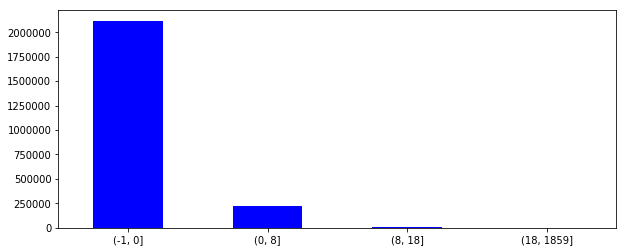

In [102]:
bins_invites = [-1,0,8,18,1859]
lenders['binned_num_invited'] = pd.cut(lenders['NUM_INVITED'],bins_invites)

ax = lenders.binned_num_invited.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(10,4))

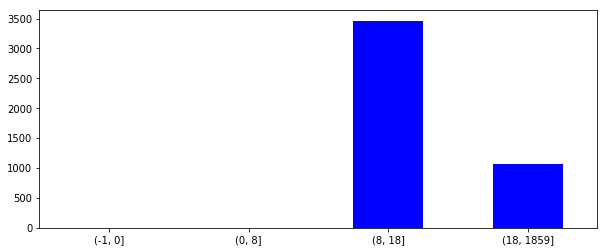

In [103]:
ax = lenders[lenders.NUM_INVITED > 8]['binned_num_invited'].value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(10,4))

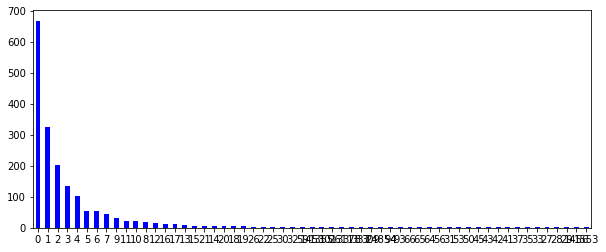

In [97]:
lenders[lenders.LOAN_PURCHASE_NUM > 1000]['NUM_INVITED'].value_counts().plot.bar(rot=0, color="b", figsize=(10,4))

### Super Connectors

In [114]:
lenders[lenders.NUM_INVITED > 19].shape[0]/lenders.shape[0]

0.00041120836515302824

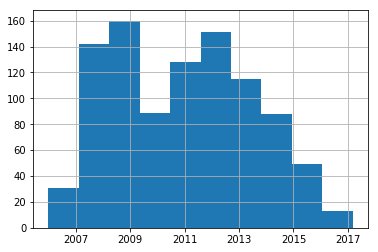

In [106]:
lenders[lenders.NUM_INVITED > 19].MEMBER_SINCE.hist()

Text(0.5,1,'LOAN_PURCHASE_NUM for supper connectors')

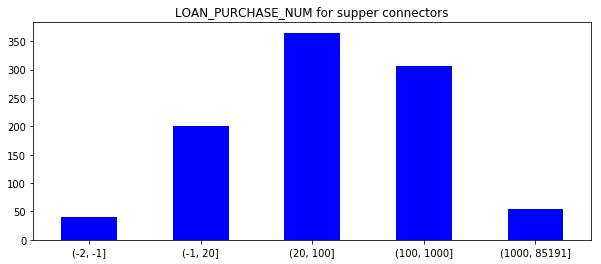

In [116]:
ax = lenders[lenders.NUM_INVITED > 19]['binned_loan_purcharse_num'].value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(10,4));
ax.set_title("LOAN_PURCHASE_NUM for supper connectors")

### Loyal Supporters

In [123]:
lenders[lenders.LOAN_PURCHASE_NUM > 0][lenders.LOAN_PURCHASE_NUM <= 10].shape[0]/lenders.shape[0]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


0.43890788847484263

In [112]:
# lenders.columns
col_list = ['CITY', 'STATE',
       'COUNTRY_CODE', 'MEMBER_SINCE', 'OCCUPATION',
'LOAN_PURCHASE_NUM', 
       'NUM_INVITED']

## Why_Loan

In [124]:
descriptions = lenders['LOAN_BECAUSE']
#Step 2. Vectorize, Stem and Lemmatize words

# vect = CountVectorizer(stop_words='english')
# model = vect.fit_transform(docs)

In [125]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import numpy as np
from bs4 import BeautifulSoup
import string


In [126]:
snowball = SnowballStemmer('english')
wordnet = WordNetLemmatizer()

In [129]:
descriptions.isnull().sum()

2174852

In [133]:
descriptions.isnull().sum()/descriptions.shape[0] #92.6% are missing 

0.9257943430329129

In [136]:
descriptions = descriptions.fillna('')

In [143]:
def tokenize(doc):
#     soup = BeautifulSoup(doc,'html.parser')
#     text = soup.get_text()
    translater = str.maketrans('','',string.punctuation)
    a = [wordnet.lemmatize(word) for word in word_tokenize(doc.lower().translate(translater))]
    return a

vect = TfidfVectorizer(stop_words='english', analyzer='word',tokenizer=tokenize)
model = vect.fit_transform(descriptions)
features = vect.get_feature_names()

In [147]:
descriptions[descriptions != '']

594        I believe its important to support others in t...
984                                    http://cracks2016.com
1045       As the bible states: ~ "Give someone a fish an...
1139                                 CMS Website Development
1243       I was introduced to Kiva on my recent visit to...
1493                                I need money for my jobs
1884       small things together matter to make the world...
1909       Nothing is more rewarding than watching people...
1949                               I want expand my business
2154       It's the right thing to do. We live in a globa...
2168                        People need help and I can help.
2284       I desire this loan to establish a creche, dayc...
2430              I want to help make a difference in world.
2488                    You can't alway's do it on your own.
2743                        Captain america civil war stream
2776                                                  700.00
2821            I'm grat

In [154]:
tokenize(descriptions[594])

['i',
 'believe',
 'it',
 'important',
 'to',
 'support',
 'others',
 'in',
 'their',
 'time',
 'of',
 'need']

In [155]:
vect.vocabulary_

{'believe': 8659,
 'important': 35463,
 'support': 69538,
 'time': 71986,
 'need': 48102,
 'httpcracks2016com': 33243,
 'bible': 9188,
 'state': 68222,
 'fish': 26754,
 'feed': 26120,
 'day': 17855,
 'net': 48410,
 'youll': 79384,
 'lifetime': 41598,
 'cm': 14108,
 'website': 77256,
 'development': 19150,
 'wa': 76738,
 'introduced': 37168,
 'kiva': 39474,
 'recent': 59476,
 'visit': 76247,
 'san': 63820,
 'francisco': 27734,
 'family': 25740,
 'member': 44776,
 'perused': 54333,
 'jessica': 38209,
 'jackleys': 37940,
 'inspirational': 36654,
 'clay': 13910,
 'water': 77014,
 'brick': 10407,
 'exactly': 24829,
 'kind': 39375,
 'organisation': 51712,
 'wanted': 76876,
 'involved': 37344,
 'nnothing': 49604,
 'better': 9066,
 'helping': 31967,
 'fellow': 26207,
 'human': 34501,
 'difficult': 19575,
 'bring': 10466,
 'smile': 66612,
 'happiness': 31334,
 'life': 41416,
 'nlive': 49345,
 'let': 41176,
 'live': 42068,
 'money': 46343,
 'job': 38340,
 'small': 66552,
 'thing': 71579,
 'matte

In [158]:
# Step 3. Build NMF model
topic_num = 

nmf_model = NMF(n_components=topic_num, random_state=1,alpha=.1, l1_ratio=.5)
W = nmf_model.fit_transform(model)
H = nmf_model.components_


In [157]:
# Step 4. Print top 10 features from each cluster
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
print_top_words(nmf_model,features,10)

Topic #0:
help need like way little able feel fortunate great good
Topic #1:
make difference life world better small place way feel little
Topic #2:
want world share blessed woman business better succeed life support
Topic #3:
people helping life believe need like way world love better
Topic #4:
care world family loan human people woman god know u



In [160]:
print_top_words(nmf_model,features,10)

Topic #0:
help people need like way helping life love great little
Topic #1:
make difference life world better small believe people way place
Topic #2:
want help world share woman blessed succeed business support change



In [161]:
import plotly

In [162]:
from sklearn.metrics import silhouette_score

## Loans EDA

In [ ]:
df[['DESCRIPTION', 'DESCRIPTION_TRANSLATED','IMAGE_ID',
              'VIDEO_ID', 'NUM_JOURNAL_ENTRIES', 'TAGS', 'NUM_BULK_ENTRIES']].head()

In [ ]:
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total Missings', 'Percent Missings'])
missing_data

In [ ]:
# Drop columns we don't need
df = df.drop(['DESCRIPTION', 'DESCRIPTION_TRANSLATED','IMAGE_ID',
              'VIDEO_ID', 'NUM_JOURNAL_ENTRIES', 'TAGS', 'NUM_BULK_ENTRIES',
              ], axis=1)

In [ ]:
df.columns

In [ ]:
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
df.head()

In [ ]:
df.STATUS.value_counts()

In [ ]:
df['diff_posted_planned'] = df['PLANNED_EXPIRATION_TIME'].sub(df['POSTED_TIME'], axis=0)
df['diff_posted_planned'] = df['diff_posted_planned'] / np.timedelta64(1, 'D')

In [ ]:
df['diff_posted_raised'] = df['RAISED_TIME'].sub(df['POSTED_TIME'], axis=0)
df['diff_posted_raised'] = df['diff_posted_raised'] / np.timedelta64(1, 'D')

In [ ]:
df.head()

In [ ]:
# Empirical expiration time is about 103 days for direct loans
df[df['DISTRIBUTION_MODEL']=='direct']['diff_posted_planned'].mean()

In [ ]:
# Empirical expiration time is about 37 days for field-partner loans
df[df['DISTRIBUTION_MODEL']=='field_partner']['diff_posted_planned'].mean()

In [ ]:
# Average time (in days) it takes to fund direct loan
df[df['DISTRIBUTION_MODEL']=='direct']['diff_posted_raised'].mean()

In [ ]:
# Average time (in days) it takes to fund field-partner loan
df[df['DISTRIBUTION_MODEL']=='field_partner']['diff_posted_raised'].mean()

In [ ]:
# Checking for missing data
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total Missings', 'Percent Missings'])
missing_data

In [ ]:
df['REPAYMENT_INTERVAL'].value_counts(1)

In [ ]:
df['STATUS'].value_counts(1)

In [ ]:
df['DISTRIBUTION_MODEL'].value_counts(1)

In [ ]:
# Group vs Individual loans
# mask_g = df['BORROWER_GENDERS']!= 'male' & df['BORROWER_GENDERS'] != 'female'
df['GROUP'] = np.where(np.logical_and(df['BORROWER_GENDERS']!= 'male', df['BORROWER_GENDERS']!= 'female'), 1, 0)

In [ ]:
df.head()

## A closer look... Individual vs. Group loans

In [ ]:
individual = df['GROUP']==0
group = df['GROUP']==1

In [ ]:
df['GROUP'].value_counts(1)

In [ ]:
df[['FUNDED_AMOUNT', 'LOAN_AMOUNT', 'LENDER_TERM', 'NUM_LENDERS_TOTAL']][group].describe().T

In [ ]:
df[['FUNDED_AMOUNT', 'LOAN_AMOUNT', 'LENDER_TERM', 'NUM_LENDERS_TOTAL']][individual].describe().T

In [ ]:
# Distribution by group
plt.figure(figsize=(20,8))
sns.distplot(df[individual]['LOAN_AMOUNT'], hist=False, color='blue', label = 'Individual', kde_kws={'clip': (0, 8000)})
sns.distplot(df[group]['LOAN_AMOUNT'], hist=False, color='purple', label = 'Group', kde_kws={'clip': (0, 8000)});
plt.axvline(df[individual]['LOAN_AMOUNT'].mean(), color="blue", linestyle="--")
plt.axvline(df[group]['LOAN_AMOUNT'].mean(), color="purple", linestyle="--")

plt.legend();

In [ ]:
# H0: mu_group - mu_individual = 0
# Ha: mu_group - mu_induvidual != 0

# alpha = 0.05

# T test
t, p = sts.ttest_ind(df[individual]['LOAN_AMOUNT'], df[group]['LOAN_AMOUNT'], equal_var=False)

# p value
print("p-value: {:2.2f}".format(p))

## Individual loans, by gender

In [ ]:
# Individual loan splitup by gender
male = df['BORROWER_GENDERS']=='male'
female = df['']=='female'

plt.figure(figsize=(20,8))
sns.distplot(df[male]['LOAN_AMOUNT'], hist=False, color='blue', label = 'Men', kde_kws={'clip': (0, 4000)});
sns.distplot(df[female]['LOAN_AMOUNT'], hist=False, color='purple', label = 'Women', kde_kws={'clip': (0, 4000)});
plt.axvline(df[male]['LOAN_AMOUNT'].mean(), color="blue", linestyle="--")
plt.axvline(df[female]['LOAN_AMOUNT'].mean(), color="purple", linestyle="--")
plt.legend();

In [ ]:
# H0: mu_male - mu_female = 0
# Ha: mu_male - mu_female != 0

# alpha = 0.05

# T test
t, p = sts.ttest_ind(df[male]['LOAN_AMOUNT'], df[female]['LOAN_AMOUNT'], equal_var=False)

# p value
print("p-value: {:2.2f}".format(p))

### Question: Is there gender inequality in access to microfinance?
Possible approach to a response: Assuming the average loan amounts are a viable proxy for gender inequality in micro-finance, we can run t-tests to see if there are significant differences between men and women's average individual loan amount by country.

In [ ]:
# Step 1: State the null and alternative hypotheses
# H0: mu_male - mu_female = 0
# Ha: mu_male - mu_female != 0

# Step 2: Significance level: 
alpha = 0.05

# Steps 3 and 4: Compute t-tests and p-values
d = {}
for country in set(df['COUNTRY_NAME']):
    t, p = sts.ttest_ind(df[male & (df['COUNTRY_NAME'] == country)]['LOAN_AMOUNT'], df[female & (df['COUNTRY_NAME'] == country)]['LOAN_AMOUNT'], equal_var=False)
    d[country] = (p <= alpha)
d

# Step 5: Compare the p-value to alpha and decide.
# True: reject H0 that there is no difference between men and women.

## More EDA to look for other interesting questions...

In [ ]:
# Count Plot by Sector
plt.figure(figsize=(15,4))
sns.countplot(x='SECTOR_NAME', data=df, orient='h', order = df['SECTOR_NAME'].value_counts().index)
plt.xticks(rotation='vertical')
plt.ylabel('Number of loans')
plt.xlabel('Sector Name')
plt.title("Number of Loans By Sector");

In [ ]:
# Calculate correlations
# df[['SECTOR_NAME', 'COUNTRY_NAME']]

# Heatmap

def count_rows(x):
    return len(x)

g = df.groupby(['SECTOR_NAME','COUNTRY_NAME']).apply(count_rows).unstack()
plt.figure(figsize=(16,4))
sns.heatmap(g, cmap='Blues', linewidth=0.5);

In [ ]:
# By Activity
df['ACTIVITY_NAME'].value_counts(1).head(10)

## Model: Field Partners vs. Direct

In [ ]:
# Field Partners
plt.figure(figsize=(16,8))
sns.boxplot(x='COUNTRY_NAME', y='LOAN_AMOUNT', data=df[df['DISTRIBUTION_MODEL']=='field_partner'])
plt.xticks(rotation='vertical')
plt.ylim(0,10000);

In [ ]:
# Direct
plt.figure(figsize=(8,4))
sns.boxplot(x='COUNTRY_NAME', y='LOAN_AMOUNT', data=df[df['DISTRIBUTION_MODEL']=='direct'])
plt.xticks(rotation='vertical');
plt.ylim(0,10000);

In [ ]:
g_country = df.groupby('COUNTRY_NAME')
g_country['LOAN_AMOUNT'].sum().sort_values(ascending=False).head(10)

In [ ]:
df.sort_values?

In [ ]:
import seaborn as sns
corr = df[['LOAN_AMOUNT', 'LENDER_TERM', 'NUM_LENDERS_TOTAL', 'GROUP']].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
           cmap='Blues')

In [ ]:
corr

In [ ]:
df[male].describe().T

In [ ]:
df[female].describe().transpose()

In [ ]:
g = sns.lmplot(x="LOAN_AMOUNT", y="NUM_LENDERS_TOTAL", hue = 'BORROWER_GENDERS',
               truncate=True, size=8, data=df[individual])
g.set_axis_labels("Loan Size", "Number of Lenders");

In [ ]:
g = sns.lmplot(x="LOAN_AMOUNT", y="NUM_LENDERS_TOTAL", hue='GROUP',
               truncate=True, size=5, data=df)
g.set_axis_labels("Loan Size", "Number of Lenders");

In [ ]:
df2 = pd.read_csv('data/loans_lenders.csv')

In [ ]:
df2.head()

In [ ]:
df.head(1)

In [ ]:
df_join = df.join(df2, on='LOAN_ID', how='left', lsuffix='LoanID')

In [ ]:
df_join.LENDERS.isnull().sum()

In [ ]:
d3 = pd.read_csv('data/lenders.csv')

In [ ]:
d3.head()

Other questions?

In [ ]:
d3.COUNTRY_CODE.value_counts(dropna=False)

# Story: What factors help the loans get fully funded faster?

## Step1. Distribtuion of the difference of post date and raised date

In [ ]:
df.head()

In [ ]:
df_clean = df.loc[df.notnull()["diff_posted_raised"],:]
df_clean = df_clean[df_clean.diff_posted_raised >= 0]

In [ ]:
df_error = df_clean[df_clean.diff_posted_raised < 0]

In [ ]:
df_clean_direct = df_clean[df_clean.DISTRIBUTION_MODEL=='direct']
df_clean_partner = df_clean[df_clean.DISTRIBUTION_MODEL=='field_partner']

In [ ]:
df_clean_partner.shape

In [ ]:
sns.distplot(df_clean_partner.diff_posted_raised)
plt.xlim(0, 100)

In [ ]:
df_clean_partner["diff_posted_planned"].hist(bins=60)

In [ ]:
df_clean.diff_posted_raised.describe()

**Median days to get posted loan fully raised are 7.8 days.
Mean is 12.6 days.**

In [ ]:
df_clean_partner["diff_posted_planned"].describe()

**Some (?) loans have a planned fund raising winder longer than 30 days. 
That explains why some loans take more than 30 days to get fully funded.**

In [ ]:
df_clean_partner[df_clean_partner.diff_posted_raised > df_clean_partner.diff_posted_planned+2]

In [ ]:
df_clean_partner.STATUS.value_counts()

## Step.2 Factors affect the speed for a loan to get fully funded

In [ ]:
plt.scatter(df_clean_partner['LOAN_AMOUNT'],df_clean_partner['diff_posted_raised'])
plt.xlim(0,55000)

In [ ]:
#sns.lmplot(x="LOAN_AMOUNT", y="diff_posted_raised",
#               truncate=True, size=5, data=df_clean_partner)

In [ ]:
(df_clean_partner[(df_clean_partner.LOAN_AMOUNT)>60000]['LOAN_AMOUNT']).hist()

In [ ]:
(df_clean_partner[(df_clean_partner.LOAN_AMOUNT)>20000]['LOAN_AMOUNT']).hist()

In [ ]:
(df_clean_partner[(df_clean_partner.LOAN_AMOUNT)<2000]['LOAN_AMOUNT']).hist()

In [ ]:
df_BKT1 = df_clean_partner[df_clean_partner.LOAN_AMOUNT <= 2000]

In [ ]:
df_BKT2 = df_clean_partner[(df_clean_partner.LOAN_AMOUNT > 2000) & (df_clean_partner.LOAN_AMOUNT <= 10000)]

In [ ]:
df_BKT3 = df_clean_partner[(df_clean_partner.LOAN_AMOUNT > 10000) & (df_clean_partner.LOAN_AMOUNT <= 50000)]

In [ ]:
df_BKT4 = df_clean_partner[(df_clean_partner.LOAN_AMOUNT > 50000) & (df_clean_partner.LOAN_AMOUNT <= 500000)]

In [ ]:
df_BKT1['LOAN_AMOUNT'].hist()

In [ ]:
df_BKT1['LOAN_AMOUNT'].describe()

In [ ]:
df_BKT2['LOAN_AMOUNT'].hist()

In [ ]:
df_BKT2['LOAN_AMOUNT'].describe()

In [ ]:
plt.scatter(df_BKT1['LOAN_AMOUNT'],df_BKT1['diff_posted_raised'])
# plt.xlim(0,55000)

In [ ]:
#plt.scatter(df_BKT1[df_BKT1['diff_posted_raised']<40]['LOAN_AMOUNT'],df_BKT1[df_BKT1['diff_posted_raised']<40]['diff_posted_raised'])


In [ ]:
# df_BKT2['LOAN_AMOUNT'].describe()

In [ ]:
df_BKT1_30=df_BKT1[df_BKT1['diff_posted_planned']<40]

In [ ]:
df_BKT1_30.shape

In [ ]:
plt.scatter(df_BKT1_30['diff_posted_raised'],df_BKT1_30['NUM_LENDERS_TOTAL'])

In [ ]:
df_BKT1_40=df_BKT1[df_BKT1['diff_posted_planned']>=40]

In [ ]:
df_BKT1_40.shape

In [ ]:
plt.scatter(df_BKT1_40['diff_posted_raised'],df_BKT1_40['NUM_LENDERS_TOTAL'])

In [ ]:
bins = list(range(0,2200,200))
df_BKT1['binned'] = pd.cut(df_BKT1['LOAN_AMOUNT'],bins)

In [ ]:
bins_post_plan = [30,35,40,60,80,106]
df_BKT1['bins_post_plan'] = pd.cut(df_BKT1['diff_posted_planned'],bins_post_plan)

In [ ]:
df_BKT1.head()

In [ ]:
df_BKT1.groupby('binned').agg({'diff_posted_raised':"mean"})

In [ ]:
df_b1_analysis = df_BKT1.groupby(['binned',"bins_post_plan"]).agg({'diff_posted_raised':"mean"}).unstack()
df_b1_analysis

In [ ]:
# corr = df[['LOAN_AMOUNT', 'LENDER_TERM', 'NUM_LENDERS_TOTAL', 'GROUP']].corr()
sns.heatmap(df_b1_analysis, 
            xticklabels=df_b1_analysis.columns.values,
            yticklabels=df_b1_analysis.index.values,
           cmap='Blues')

In [ ]:
df_BKT1.groupby(['SECTOR_NAME','binned','bins_post_plan']).agg({'diff_posted_raised':"mean"}).unstack()

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(df_BKT1.groupby(['SECTOR_NAME','bins_post_plan']).agg({'diff_posted_raised':"mean"}).unstack())

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(df_BKT1.groupby(['SECTOR_NAME','binned']).agg({'diff_posted_raised':"mean"}).unstack())


In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(df_BKT1.groupby(['NUM_LENDERS_TOTAL','binned']).agg({'diff_posted_raised':"mean"}).unstack())

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(df_BKT1.groupby(['COUNTRY_NAME','binned']).agg({'diff_posted_raised':"mean"}).unstack())

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(df_BKT1[df_BKT1['GROUP']!=True].groupby(['BORROWER_GENDERS','binned']).agg({'diff_posted_raised':"mean"}).unstack())

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(df_BKT1.groupby(['ORIGINAL_LANGUAGE','binned']).agg({'diff_posted_raised':"mean"}).unstack())

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(df_BKT1[df_BKT1['GROUP']!=True].groupby(['SECTOR_NAME','BORROWER_GENDERS']).agg({'diff_posted_raised':"median"}).unstack())

In [ ]:
df_BKT1[df_BKT1['GROUP']!=True].groupby(['SECTOR_NAME','BORROWER_GENDERS']).agg({'diff_posted_raised':"median"}).unstack()

In [ ]:
# H0: mu_group - mu_individual = 0
# Ha: mu_group - mu_induvidual != 0

# alpha = 0.05

# T test
t, p = sts.ttest_ind(df_BKT1[df_BKT1['BORROWER_GENDERS']=='male']['diff_posted_raised'], df_BKT1[df_BKT1['BORROWER_GENDERS']=='female']['diff_posted_raised'], equal_var=False)

# p value
print("p-value: {:2.2f}".format(p))

In [ ]:
# H0: mu_group - mu_individual = 0
# Ha: mu_group - mu_induvidual != 0

# alpha = 0.05

# T test
t, p = sts.ttest_ind(df_BKT1[df_BKT1['SECTOR_NAME']=='Arts']['diff_posted_raised'], df_BKT1[df_BKT1['SECTOR_NAME']=='Clothing']['diff_posted_raised'], equal_var=False)

# p value
print("p-value: {:2.2f}".format(p))

In [ ]:
 # H0: mu_group - mu_individual = 0
# Ha: mu_group - mu_induvidual != 0

# alpha = 0.05

# T test
t, p = sts.ttest_ind(df_BKT1[df_BKT1['GROUP']==1]['diff_posted_raised'], df_BKT1[df_BKT1['GROUP']==0]['diff_posted_raised'], equal_var=False)

# p value
print("p-value: {:2.2f}".format(p))

In [ ]:
df_BKT1.corr()

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(df_BKT1.corr())

## Other people's work


### similiar findings
- exclude direct, big companies 


### Scott's to calculte optimal bins for histgram




### t-test & p-value for gender / sector / group | individual 


- more men published video than women (proportion t-test)

- half of the countries 







we should filter by 'funded'

## see the trend day by day 